# Setup

In [30]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay 
#importar clase regresion logistica
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Loading and exploring the data

In [2]:
def fetch_data(ID):
    original_ds = fetch_ucirepo(id=ID)
    df = pd.concat([original_ds.data.features,original_ds.data.targets], axis = 1)
    return df

def explore_data(data):
    print(data.head().T)
    print(data.describe())
    print(data.info()) 

# Visualizing the data

In [3]:
def plot_histograms(data):
    data.hist(bins=15, figsize=(15, 10))
    plt.show()

def plot_correlation_matrix(data):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()
    
def plot_feature_relationships(data, target):
    for column in data.columns[:-1]:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=target, y=column, data=data)
        plt.title(f'Relationship between Cervical cancer and {column}')
        plt.show()




# Preprocessing and feature engineering

In [4]:
def delete_outliers(data):
    print("Aplicando operación: Borrado de outliers")
    numeric_columns = data.select_dtypes(include='number').columns
    # calcualr el IQR para cada columna
    Q1 = data[numeric_columns].quantile(0.25)
    Q3 = data[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1

    # calcula los limites inferiores y superiores
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # se determina una df the valores booleanos: True si es un outlier, False si no
    outliers = ((data[numeric_columns] < lower_bound) | (data[numeric_columns] > upper_bound))

    #se usa el df de booleanos para filtrar los outliers
    cleaned_data = data[~outliers.any(axis=1)]
    return cleaned_data

def normalization(data):
    print("Aplicando operación: Normalización logaritmica y raiz cuadrada")
    skew = data.skew()
    log_transform_columns = []
    sqrt_transform_columns = []
    for index, value in skew.items():
        if value <= -1: 
            log_transform_columns.append(index)
        elif value > -1 and value < -0.5:
            sqrt_transform_columns.append(index)

    normalized = data.copy()

    # Transformación logarítmica: Reduce el impacto de valores extremos. Ideal para variables con sesgo positivo.

    normalized[log_transform_columns] = normalized[log_transform_columns].apply(np.log1p)

    # Transformación de raíz cuadrada: Similar a la logarítmica, pero menos agresiva. Funciona bien para variables con valores más pequeños o negativos con sesgo positivo o negativo.
    normalized[sqrt_transform_columns] = normalized[sqrt_transform_columns].apply(np.sqrt)

    return normalized

def aplicar_pca(data, target, threshold = 0.90):
    print("Aplicando operación: PCA")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data.drop(columns=[target]))  # Excluir la variable objetivo
    # Aplicar PCA
    pca = PCA().fit(X_scaled)
    # Calcular la varianza explicada acumulada
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(explained_variance >= threshold) + 1
    pca = PCA(n_components=num_components)  # Número de componentes principales
    X_pca = pca.fit_transform(X_scaled)
    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]  # Nombrar los componentes como PC1, PC2, etc.
    df_pca = pd.DataFrame(X_pca, columns=pca_columns)
    df_pca['y'] = data[target].values
    return df_pca

# Splitting the dataset

In [5]:
def split_data(data, target, test_size=0.2, val_size = 0.50, random_state=42):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state)
    return X_train, X_test, X_val, y_train, y_test, y_val

# Training the model

In [14]:
def model(X_train,y_train,X_val,y_val):
    solver = 'liblinear'
    multi_class = 'ovr'
    model_train = LogisticRegression(random_state= 10, solver = solver, multi_class=multi_class)
    model_train.fit(X_train, y_train)                               
    y_pred_val = model_train.predict(X_val)
    return y_pred_val, model_train

# Evaluating the model

In [34]:
def model_test_eval(X_test, y_test, model):
    y_pred_test = model.predict(X_test)
    return y_pred_test
     

def conf_matrix(y, y_pred):
    cnf_matrix = metrics.confusion_matrix(y, y_pred)
    print("Confusion matrix")
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix) 
    disp.plot(colorbar = False, cmap='viridis') 
    plt.show()

def classif_report(y, y_pred):
    target_names = ['without cervical cancer', 'with cervical cancer']
    print(classification_report(y, y_pred, target_names=target_names, zero_division=0.0))

# Cross Validation

In [24]:
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv)
    print("Average accuracy with CV:", np.mean(scores))

# Main function

In [32]:
def main(ID):
    data = fetch_data(ID)
    explore_data(data)
    plot_histograms(data)
    plot_correlation_matrix(data)
    plot_feature_relationships(data, 'ca_cervix')
    del_outliers = delete_outliers(data)
    data_normalized = normalization(del_outliers)
    data_pca = aplicar_pca(data_normalized,'ca_cervix',0.9)
    X_train, X_test, X_val, y_train, y_test, y_val = split_data(data_pca, 'y', test_size = 0.30)
    print('Evaluación del modelo con dataset de evaluación')
    model_val_predictions, trained_model = model(X_train,y_train,X_val,y_val)
    conf_matrix(y_val,model_val_predictions)
    classif_report(y_val,model_val_predictions)
    print('Evaluación del modelo con dataset de pueba')
    model_test_predictions = model_test_eval(X_test,y_test, trained_model)
    conf_matrix(y_test, model_test_predictions)
    classif_report(y_test, model_test_predictions)
    print('Validación cruzada')
    cross_validate_model(trained_model, data_pca.drop('y', axis=1), data_pca['y'])
    
    

# Execute

                             0   1   2   3   4
behavior_eating             13  11  15  11  11
behavior_personalHygiene    12  11   3  10   7
intention_aggregation        4  10   2  10   8
intention_commitment         7  14  14  15  10
attitude_consistency         9   7   8   7   7
attitude_spontaneity        10   7  10   7   8
norm_significantPerson       1   5   1   1   1
norm_fulfillment             8   5   4   5   5
perception_vulnerability     7   4   7   4   3
perception_severity          3   2   2   2   2
motivation_strength         14  15   7  15  15
motivation_willingness       8  13   3  13   5
socialSupport_emotionality   5   7   3   7   3
socialSupport_appreciation   7   6   6   4   6
socialSupport_instrumental  12   5  11   4  12
empowerment_knowledge       12   5   3   4   5
empowerment_abilities       11   4   3   4   4
empowerment_desires          8   4  15   4   7
behavior_sexualRisk         10  10  10  10   8
ca_cervix                    1   1   1   1   1
       behavi

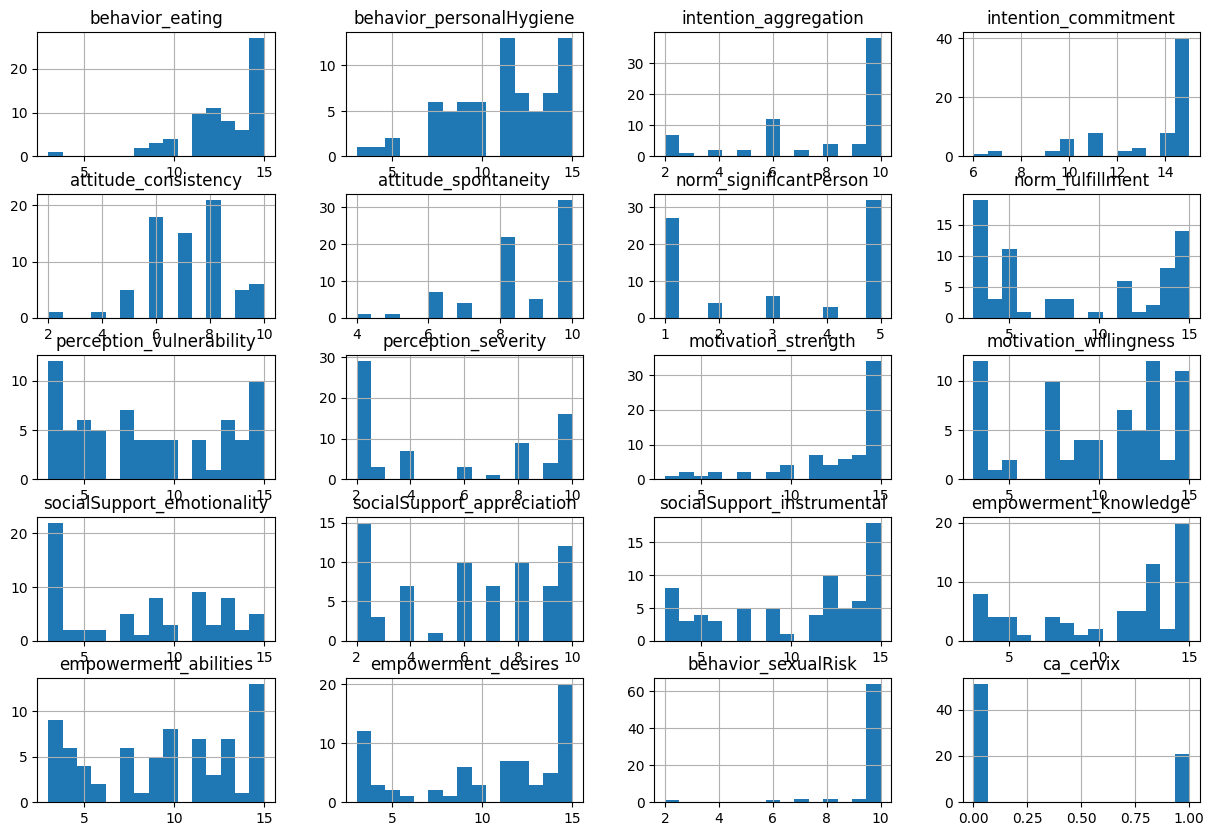

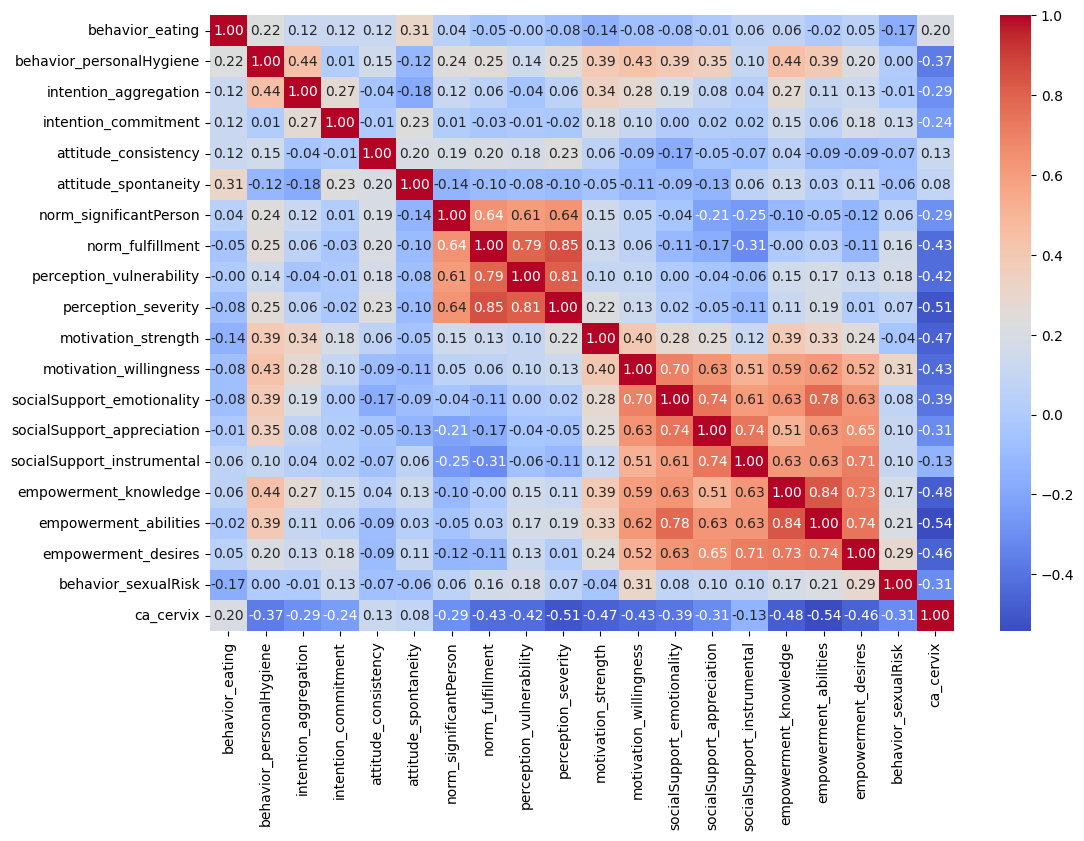

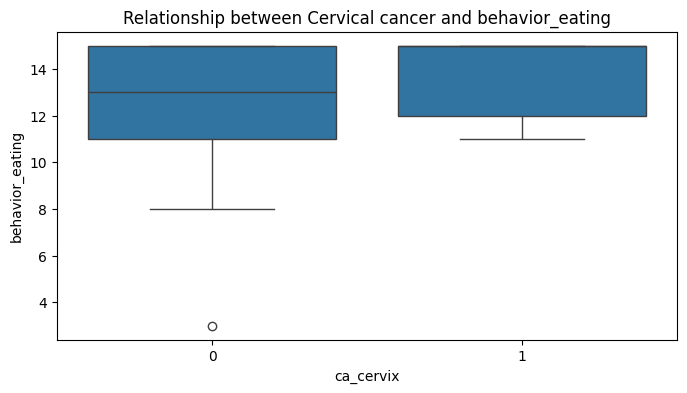

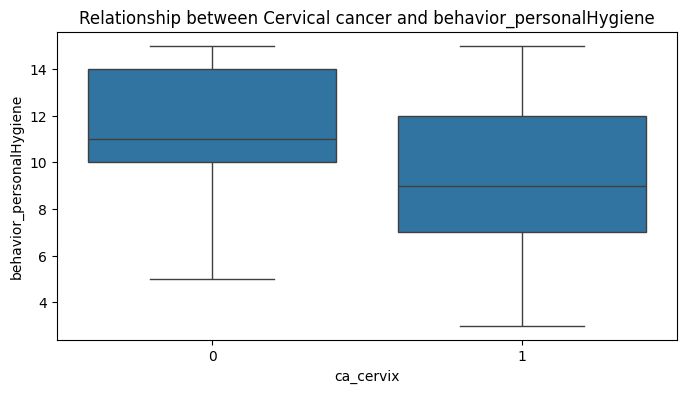

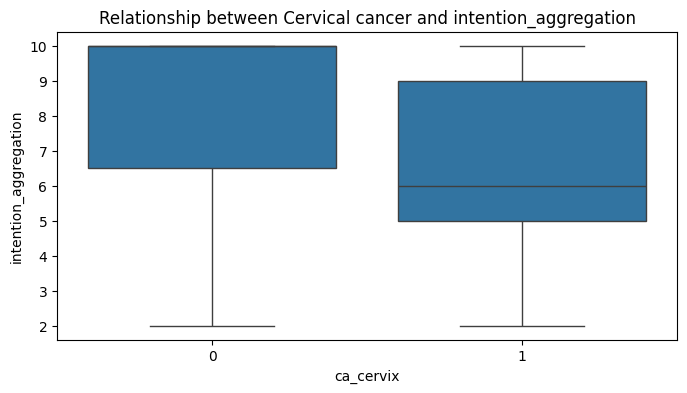

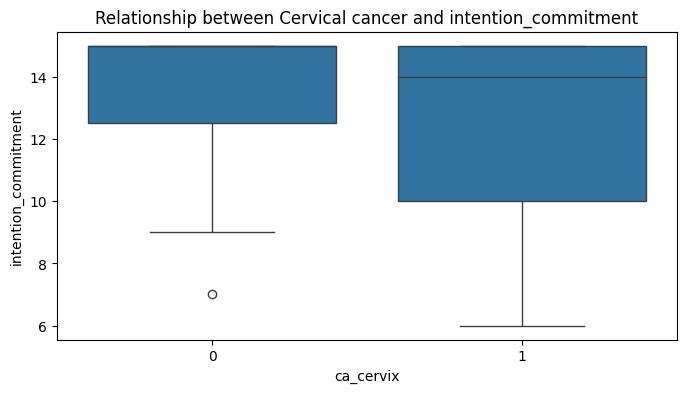

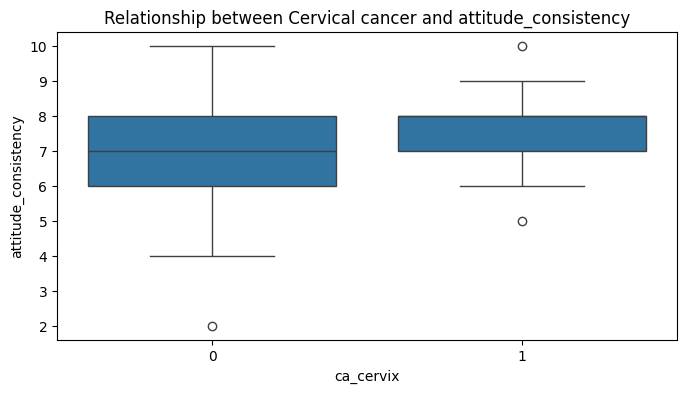

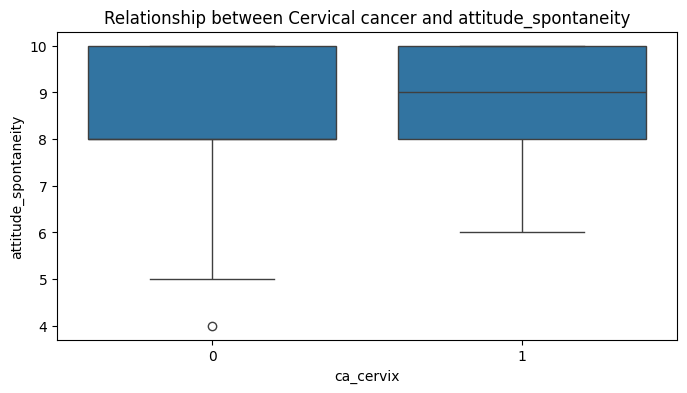

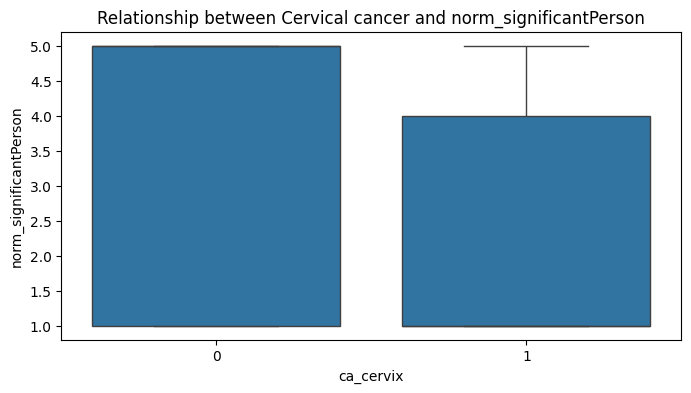

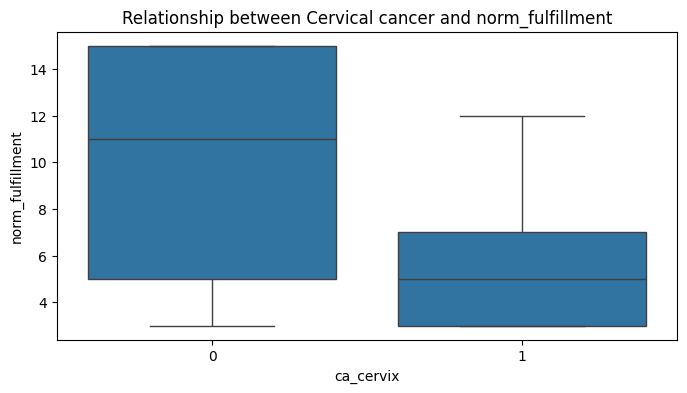

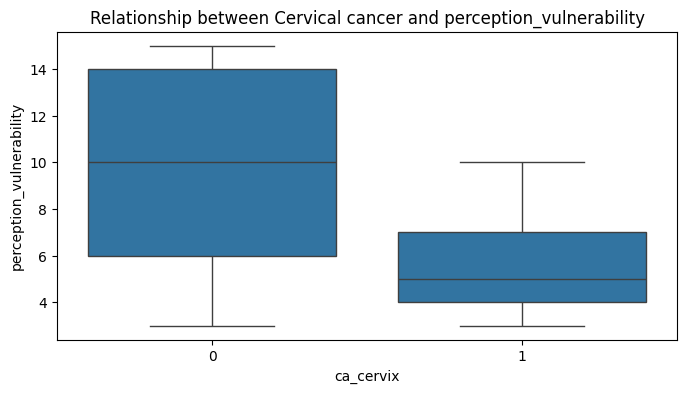

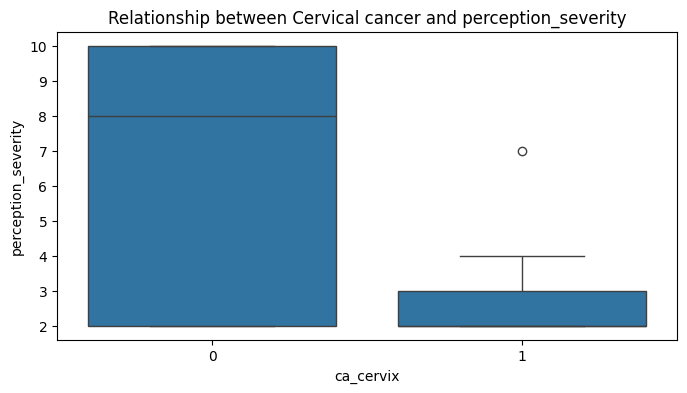

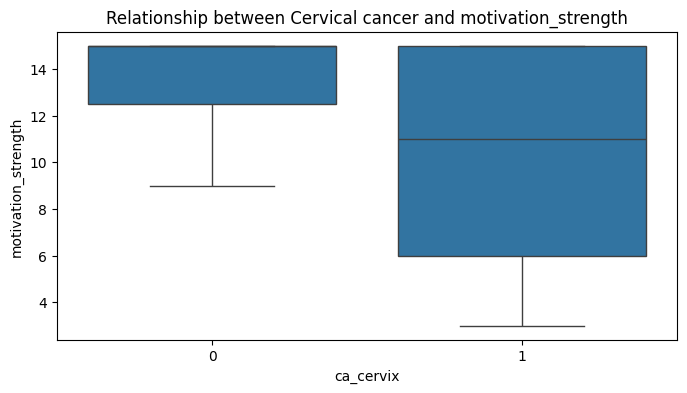

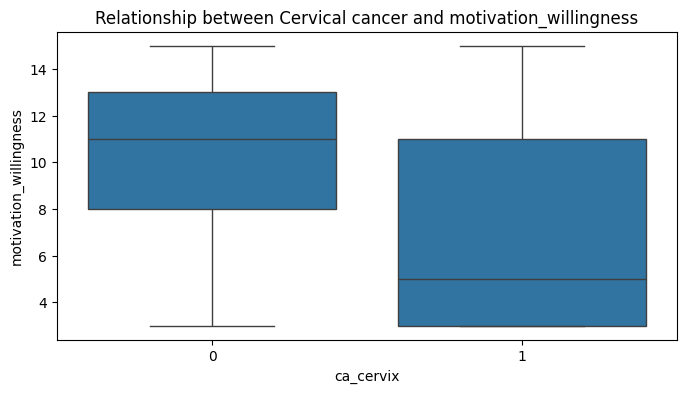

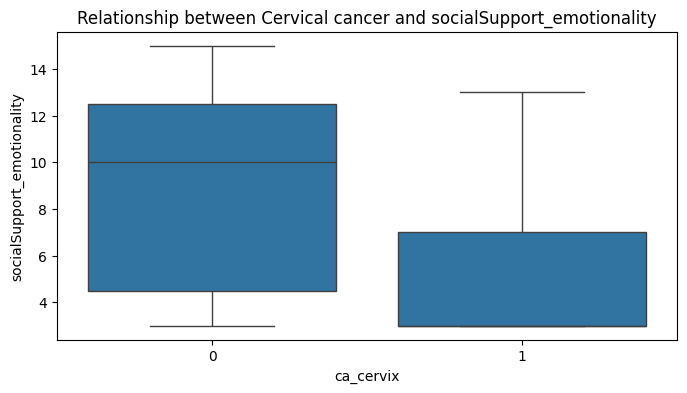

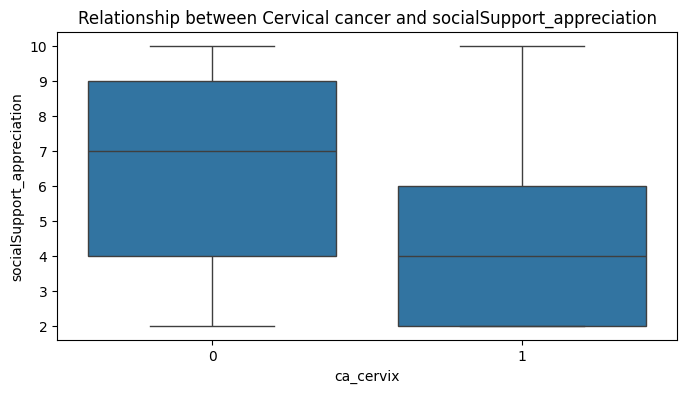

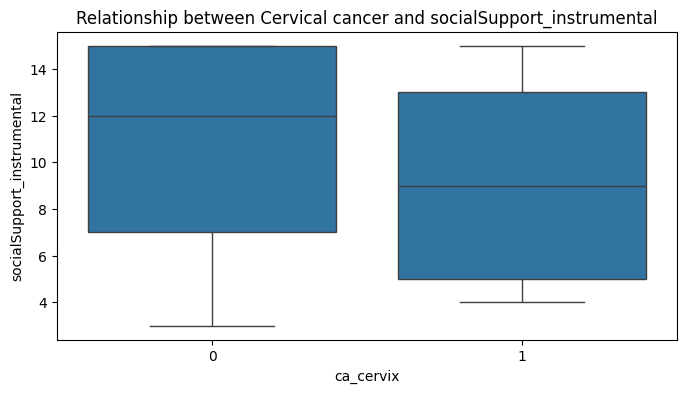

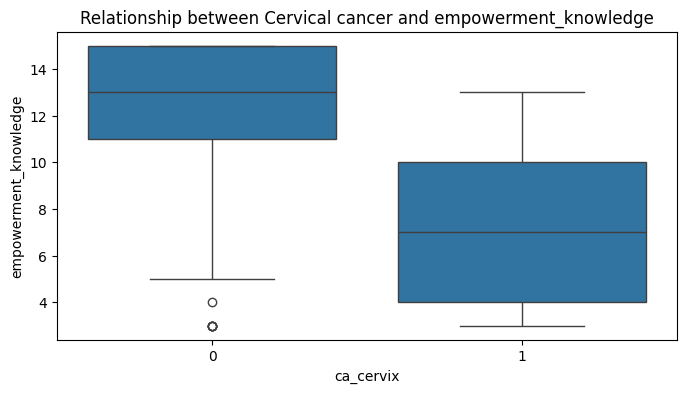

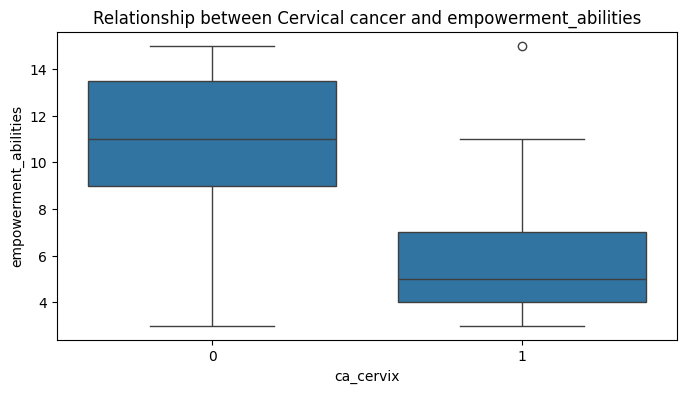

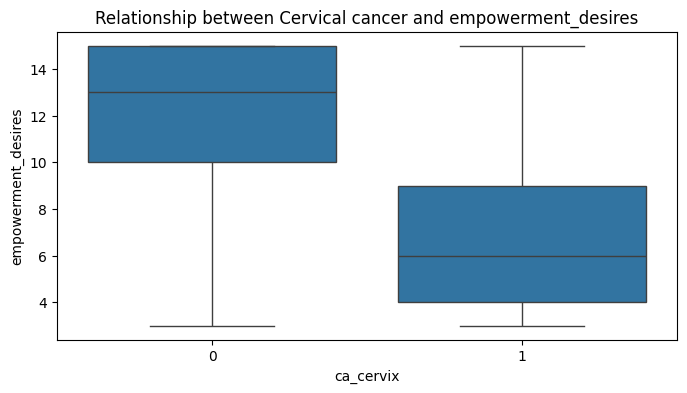

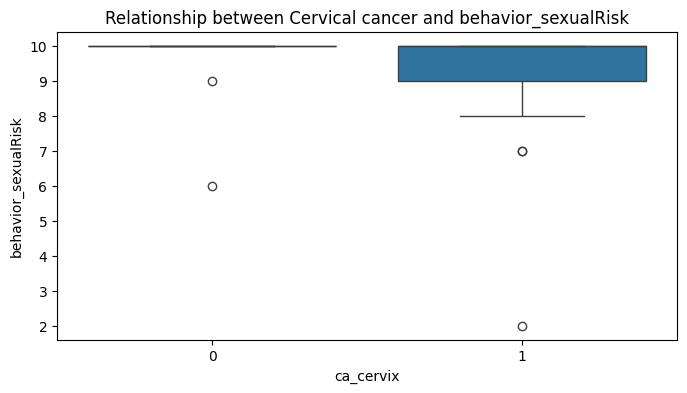

Aplicando operación: Borrado de outliers
Aplicando operación: Normalización logaritmica y raiz cuadrada
Aplicando operación: PCA
Evaluación del modelo con dataset de evaluación
Confusion matrix


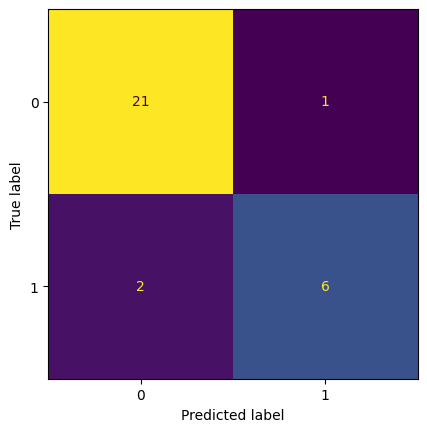

                         precision    recall  f1-score   support

without cervical cancer       0.91      0.95      0.93        22
   with cervical cancer       0.86      0.75      0.80         8

               accuracy                           0.90        30
              macro avg       0.89      0.85      0.87        30
           weighted avg       0.90      0.90      0.90        30

Evaluación del modelo con dataset de pueba
Confusion matrix


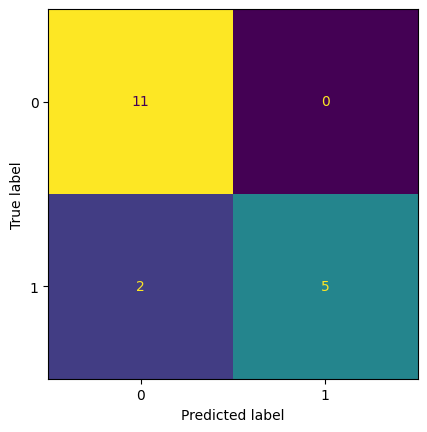

                         precision    recall  f1-score   support

without cervical cancer       0.85      1.00      0.92        11
   with cervical cancer       1.00      0.71      0.83         7

               accuracy                           0.89        18
              macro avg       0.92      0.86      0.88        18
           weighted avg       0.91      0.89      0.88        18

Validación cruzada
Average accuracy with CV: 0.8318181818181818


In [33]:
main(537)